# Определение возраста покупателей

# Описание проекта

* **Сфера деятельности**: продажа продуктов (сетевой супермаркет)

* **Цель**: построить модель, которая по фотографии определит приблизительный возраст человека. Данная модель поможет:
    - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    - контролировать добросовестность кассиров при продаже алкоголя

* **Ключевые критерии качества модели** (в порядке приоритетности):
    - **MAE < 8**

* **Задачи**:
    - Провести исследовательский анализ набора фотографий.
    - Подготовить данные к обучению.
    - Обучить нейронную сеть и рассчитайте её качество.


In [22]:
# импорт библиотек для работы 
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 12345
PATH = '/datasets/faces/'
IMAGE_DIR = PATH + 'final_files/'

## Исследовательский анализ данных

In [23]:
# загрузка CSV файла
df = pd.read_csv(PATH + 'labels.csv')

print(f'Размер выборки: {df.shape}')

Размер выборки: (7591, 2)


In [24]:
def load_data(df, path):
    # Train datagenerator
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255) # приводим значения к шкале [0, 1]
    # Validation datagenerator
    valid_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255) # приводим значения к шкале [0, 1]
    # Train datagenerator
    train_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                   directory=path,
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   class_mode='raw',
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   subset='training',
                                                   seed=SEED)
    # Validation datagenerator
    valid_flow = valid_datagen.flow_from_dataframe(dataframe=df,
                                                   directory=path,
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   class_mode='raw',
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   subset='validation',
                                                   seed=SEED)
    return train_flow, valid_flow

In [25]:
train_flow, valid_flow = load_data(df, IMAGE_DIR)

# Из обучающей выборки
x, y = next(train_flow)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [49]:
df['real_age'].value_counts().max()

317

In [43]:
print(df['real_age'].describe())
print()
na_count = df['real_age'].isna().sum()
print(f'Число пропусков в разметке: {na_count}')
print()
print(df['real_age'].value_counts())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Число пропусков в разметке: 0

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64


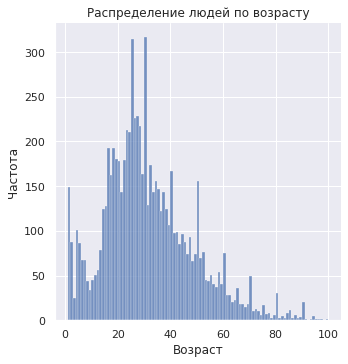

In [76]:
# Распределение людей по возрасту
sns.displot(df['real_age'], binwidth=1).set(xlabel='Возраст', 
                                            ylabel='Частота', 
                                            title = 'Распределение людей по возрасту')


<AxesSubplot:ylabel='real_age'>

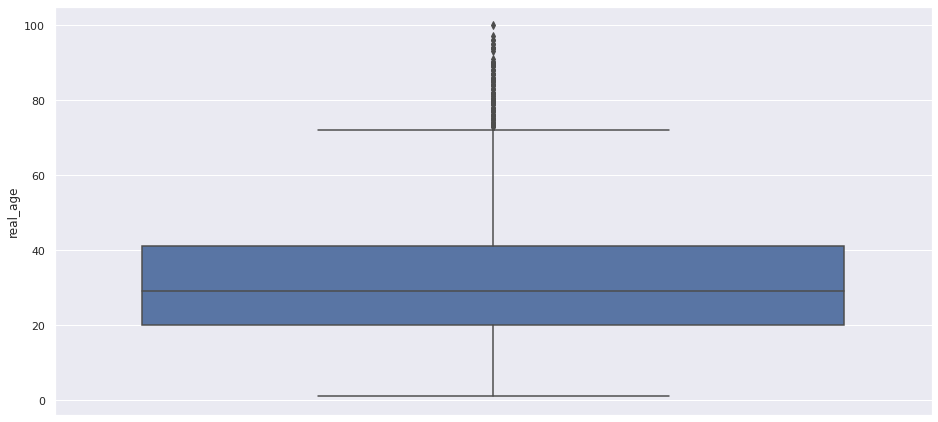

In [77]:
# Коробчатая диаграмма
sns.boxplot(data=df, y='real_age')

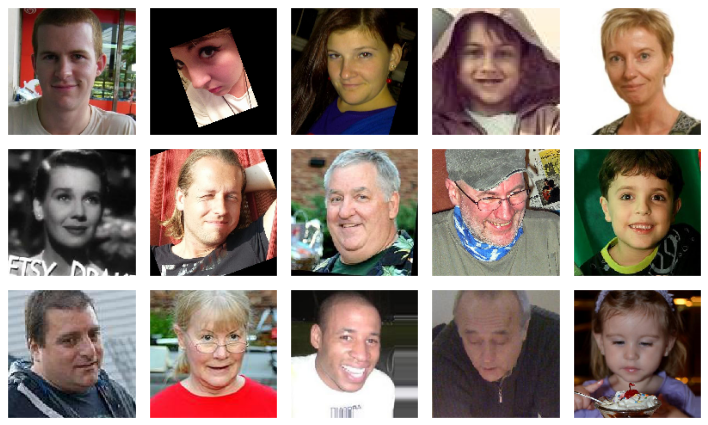

In [79]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(X[i])
    
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Краткие выводы:**
* Выгрузка данных произведена успешно
* Из распределния людей по возрасту в нашей выборке можно сделать выводы, что меньше всего людей представлено в старших возрастах.
* На гистограмме распределения видны отдельные пики. В частности, интересно видеть что довольно много фото людей в возрасте от 1 года до 8 лет. Однако несмотря на казалось бы задачу определения возраста клиентов (которым едва будет столько лет) для обучения наличие таких данных необходимо. Во-превых, исходя из целей построения моделей нам важны и детти (не продают ли им что-то не по закону). Всплески в ближе к середине распределения, вероятно, не столь сильно повлияют на обучение модели, поскольку в данном диапазоне точность определения возраста до года не столь важана. Однако возможна проблема переобучения для этой возрастной группы. Думаю сперва стоит оставить эту группу так. Что касает правого хвоста распределения, то он немногочислене и в генеральной совокупности. В целом как мне кажется, распределение по возрасту в нашей выборке должно стремиться к нормальному распределению. Поскольку и в жизни в магазин будут приходить клиенты образуя нормальное распределение (по закону больших чисел и ЦПТ).
* Вариация данных на фотогравиях присутсвует. Мы видим, что много фото представленных не в формате "паспортного фото". Это также важно поскольку в рельных условиях модели нужно будет определять лица с учетом возможных наклонов, наличие акссесуаров (очков, например). В выборке присутсвуют даже чернобелые фото (как будто с постера строго кино).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError


def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    train_data = train_datagen.flow_from_dataframe(dataframe = labels, 
                                                   directory = path + 'final_files/', 
                                                   x_col='file_name', y_col='real_age', 
                                                   subset = 'training', 
                                                   target_size = (244, 244), 
                                                   batch_size = 32, 
                                                   class_mode='raw', 
                                                   seed=12345, 
                                                   horizontal_flip=True, 
                                                   vertical_flip=True)
    
    return train_data

def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    test_data = test_datagen.flow_from_dataframe(dataframe = labels, 
                                                 directory = path + 'final_files/', 
                                                 x_col='file_name', y_col='real_age', 
                                                 subset = 'validation', 
                                                 target_size = (244, 244), 
                                                 batch_size = 32, 
                                                 class_mode='raw', 
                                                 seed=12345)
    
    return test_data

def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    backbone=ResNet50(input_shape=input_shape, weights = 'imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7, 
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, validation_data=test_data, steps_per_epoch=steps_per_epoch, 
              validation_steps = validation_steps,
             verbose=1, epochs=epochs, batch_size=batch_size)
    return model

```

```
60/60 - 10s - loss: 72.7658 - mae: 6.6654
Test MAE: 6.6654

```

## Анализ обученной модели

**Чтобы получить такой результат я использовал предобученную архитектуру ResNet50 на данных imagenet (использовал horizontal и vertical flips). Средняя абсолютная ошибка ниже 7, что является отличным результатом по условиям задачи (т.е. в среднем модель ошибается примерно на шесть с половиной лет. Учитывая нашу специфику, то такой результат можно считать приемлемым . Модели понадобилось 7 эпох, а параметр learning rate оптимизатора Adam равен 1e-4.